In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fast_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 737 kB/s 


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, auc, confusion_matrix, f1_score, precision_recall_curve, SCORERS
from sklearn.model_selection import KFold, cross_val_score

%matplotlib inline

In [43]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-09-29 14:15:55--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv.1’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.01s   

2022-09-29 14:15:55 (5.39 MB/s) - ‘AER_credit_card_data.csv.1’ saved [73250/73250]



In [44]:
df=pd.read_csv('AER_credit_card_data.csv')
data=df.copy()

In [45]:
df.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [47]:
cat={'yes':1,'no':0}

In [48]:
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [49]:
#df.card=(df.card == 'yes').astype('int')
df.card=df.card.map(cat)
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [50]:
df.owner=(df.owner == 'yes').astype('int')
df.selfemp=(df.selfemp == 'yes').astype('int')

In [51]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target='card',train_size=0.6,valid_size=0.2,test_size=0.2, random_state=1)

In [64]:
cols=['reports','dependents','active','share']

for col in cols:
    auc = roc_auc_score(y_valid, X_valid[col])
    if auc < 0.5:
        auc = roc_auc_score(y_valid, -X_valid[col])
    print(f'{col}: {auc:.3f}')


reports: 0.761
dependents: 0.546
active: 0.529
share: 0.985


In [65]:
cols=['reports','dependents','active','share']
lr=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

for col in cols:

  lr.fit(X_train[col].values.reshape(-1,1),y_train.values.reshape(-1,1))

  #Probability of class 1
  y_pred=lr.predict_proba(X_test[col].values.reshape(-1,1))[:,1]

  print(f'{col}: {roc_auc_score(y_test,y_pred):.3f}')



reports: 0.726
dependents: 0.518
active: 0.569
share: 0.994


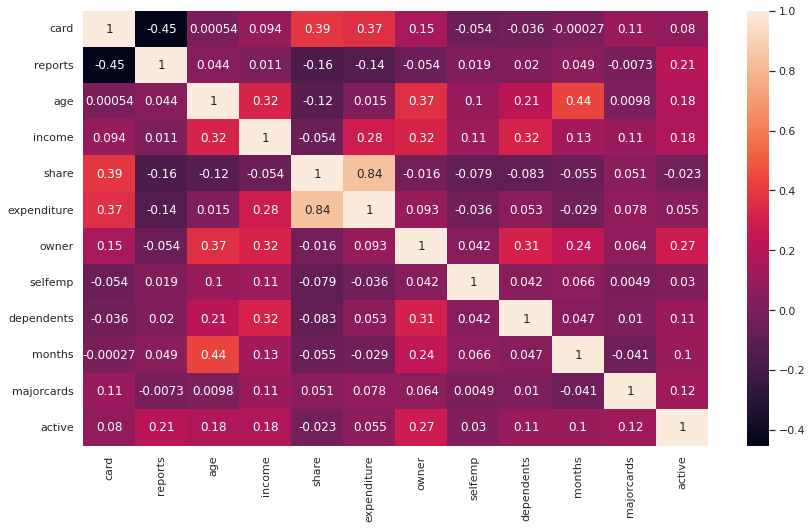

In [66]:
sns.set()
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(),annot=True)

In [71]:

c=["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

LR=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

LR.fit(X_train[c],y_train)

#Test set
Y_Pred=LR.predict_proba(X_test[c])[:,1]

#On validation set
y_pred=LR.predict_proba(X_valid[c])[:,1]

In [68]:
round(roc_auc_score(y_test,Y_Pred),3)

0.995

In [70]:
print('Scores for Test Set:\n')

t = [y for y in [0.1,0.4,0.6,0.7]]
for thr in t:
  acc=accuracy_score(y_test,np.array((Y_Pred >= thr).astype('int')))
  f1=f1_score(y_test,np.array((Y_Pred >= thr).astype('int')))
  print(f'threshold {thr}: accuracy {acc:.5f}: f1 score {f1:.8f}')

Scores for Test Set:

threshold 0.1: accuracy 0.94697: f1 score 0.96803653
threshold 0.4: accuracy 0.98864: f1 score 0.99294118
threshold 0.6: accuracy 0.98864: f1 score 0.99294118
threshold 0.7: accuracy 0.98864: f1 score 0.99294118


In [73]:
print('Scores for Validation Set:\n')

t = [y for y in [0.1,0.4,0.6,0.7]]
for thr in t:
  acc=accuracy_score(y_valid,np.array((y_pred >= thr).astype('int')))
  f1=f1_score(y_valid,np.array((y_pred >= thr).astype('int')))
  print(f'threshold {thr}: accuracy {acc:.5f}: f1 score {f1:.8f}')

Scores for Validation Set:

threshold 0.1: accuracy 0.94318: f1 score 0.96487119
threshold 0.4: accuracy 0.97348: f1 score 0.98305085
threshold 0.6: accuracy 0.97348: f1 score 0.98305085
threshold 0.7: accuracy 0.97348: f1 score 0.98305085


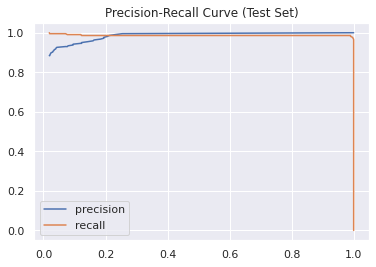

In [60]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, Y_Pred)

thresholds=np.append(thresholds,1)
#create precision recall curve
fig, ax = plt.subplots()

plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')

# # #add axis labels to plot
ax.set_title('Precision-Recall Curve (Test Set)')
plt.legend()
# # #display plot
plt.show()

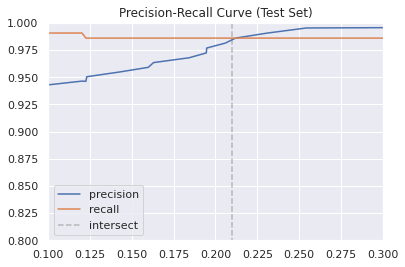

In [74]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, Y_Pred)
thresholds=np.append(thresholds,1)
#create precision recall curve
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
#add axis labels to plot
plt.title('Precision-Recall Curve (Test Set)')
plt.vlines(0.21,0, 1, color='grey', linestyle='--', alpha=0.5, label='intersect')
plt.ylim(0.8,1)
plt.xlim(0.1,0.3)
plt.legend()
# # #display plot
plt.show()

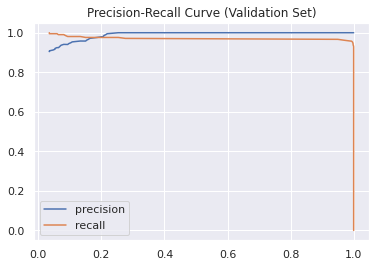

In [75]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred)

thresholds=np.append(thresholds,1)
#create precision recall curve
fig, ax = plt.subplots()

plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')

# # #add axis labels to plot
ax.set_title('Precision-Recall Curve (Validation Set)')
plt.legend()
# # #display plot
plt.show()

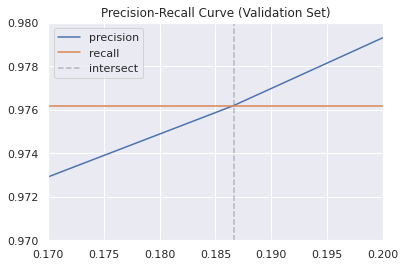

In [85]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred)
thresholds=np.append(thresholds,1)
#create precision recall curve
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
#add axis labels to plot
plt.title('Precision-Recall Curve (Validation Set)')
plt.vlines(0.1867,0, 1, color='grey', linestyle='--', alpha=0.5, label='intersect')
plt.ylim(0.97,0.98)
plt.xlim(0.170,0.20)
plt.legend()
# # #display plot
plt.show()

In [86]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [87]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)

In [90]:
X=df[c]
y=df['card']
#scores=[]

In [89]:
# create model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.995 (0.002)


In [ ]:
scores

array([0.99586777, 0.99231486, 0.99815906, 0.99651256, 0.99462125])

In [ ]:
C=[0.01, 0.1, 1, 10]
for c in C:
  print(f'\nFor C -> {c}')
  model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
  # report performance
  print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


For C -> 0.01
Accuracy: 0.992 (0.004)

For C -> 0.1
Accuracy: 0.995 (0.003)

For C -> 1
Accuracy: 0.995 (0.002)

For C -> 10
Accuracy: 0.996 (0.002)
